In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
mpl.style.use('seaborn')
plt.rcParams['axes.facecolor'] = '#f0f4f7'
plt.rc('legend', frameon=True,fancybox=True, framealpha=1)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

blue = '#4C72B0'
green = '#55A868'
red = '#C44E52'
purple = '#8172B2'
yellow = '#CCB974'
lightblue = '#64B5CD'

import importlib
import os
from os import path
import sys
import platform
import qgrid

import dill as pickl

from sync_class import SyncPhenosys
from sync_class import SyncPybpod

from eda_class import SpikesEDA
from behavior_class import BehaviorAnalysis
from sda_class import SpikesSDA
from report_class import SpikesReport

from analyze_phenosys import *

from projectthesis_plots import *

from sync_postprocessing import *

%load_ext autoreload
%autoreload 2


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


import warnings
warnings.filterwarnings('ignore')


window = 2000
iterations = 1000
bins = 50


# list -> [ session_name, [ttl_missing_rows], load_spikes, [spikes_trials_skip] ]
se_li = [('JG14_190621', [1900,1931,1996,2058,2127],True,[(0,6),(215,'end')]),
         ('JG14_190619', [111, 2781],False,[(0,1),(259,'end')]),
         ('JG14_190626', [1428, 1824, 1838, 2861, 2910, 3089, 3245, 3430, 3443],False,[(0,1),(276,'end')]),
         ('JG15_190722', [2094, 2574, 2637, 2808, 2831, 3499],False,[(271,'end')]),
         ('JG15_190725', [366,711,1487,1578,1659,2221,2666,2720,2769,2847,3371,3476],False,[(184,'end')]),
         ('JG18a_190814', [405,2621,2693,2770,2959,3015,3029,3038,3048],False,[(307,'end')]),
         ('JG18b_190828', [1744, 2363, 2648, 2701, 2731, 2778,2953,2967],True,[(0,0),(204,'end')]),
         ]



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%time
all_sessions_dict = dict()
# load all sessions into dict
for session_name,missing_rows_ttl,load_spikes,spikes_trials_skip in se_li:
    all_sessions_dict[session_name]=load_session(session_name, missing_rows_ttl, load_spikes, spikes_trials_skip)


all_sessions_dict['JG15_190722'].sync.combined_df.loc[(131,32,428,6),"Delta (TTL-CSV)"]=30

sessions_info_df=get_trial_info(all_sessions_dict)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs
JG14_190621 -> sda
JG14_190619 -> behavior
JG14_190626 -> behavior
JG15_190722 -> behavior
JG15_190725 -> behavior
JG18a_190814 -> behavior
JG18b_190828 -> sda


# Chapter Results Sync Phenosys

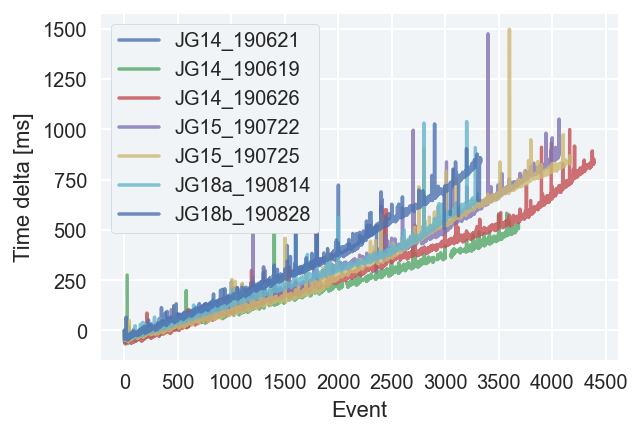

In [91]:
fig,ax = plt_trial_length(all_sessions_dict,figsize=set_size(0.8))
save_fig("ttl_delta", fig)

y = 0.20581 * x + 0.00002 * x^2 + -27.62327
y = 0.16904 * x + 0.00001 * x^2 + -46.18029
y = 0.15881 * x + 0.00002 * x^2 + -41.63060
y = 0.12846 * x + 0.00003 * x^2 + -18.38659
y = 0.12831 * x + 0.00003 * x^2 + -35.83041
y = 0.11275 * x + 0.00003 * x^2 + -15.81575
y = 0.16590 * x + 0.00004 * x^2 + -15.16294


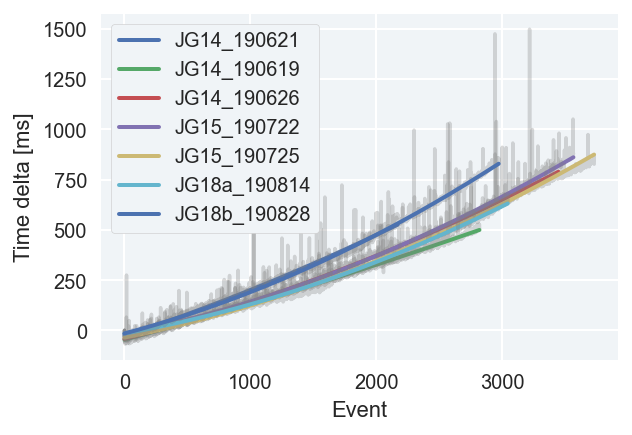

In [66]:
fig,ax = plt.subplots(1,1,figsize=set_size(0.8))
max_x = 0
fit_curves_pol = list()

for key,se in all_sessions_dict.items():
    x,y,x_line,y_line = fit_curve(se,'pol')
    label=se.sync.session
    plt_fit_curve(ax,x,y,x_line,y_line,label)
    fit_curves_pol.append([label,x,y,x_line,y_line])
    
ax.set_xlabel("Event")
ax.set_ylabel("Time delta [ms]")
ax.legend(loc=2)

save_fig("ttl_delta_fitted_pol", fig)

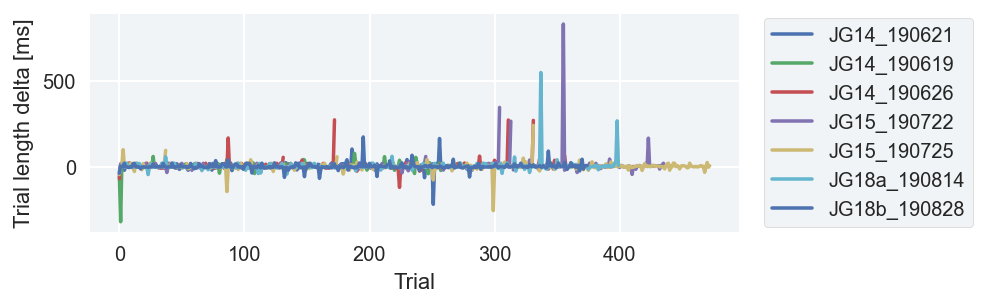

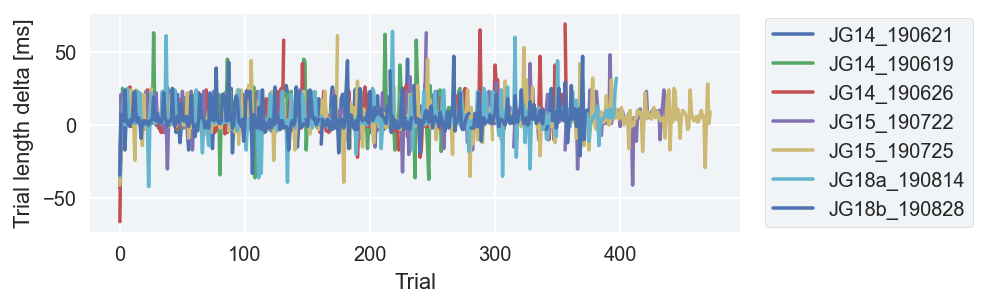

In [67]:
fig,ax = plt_trial_length_dif(all_sessions_dict,outlier=True,figsize=set_size(1.1))
save_fig("trial_length_all", fig)

fig, ax = plt_trial_length_dif(all_sessions_dict,figsize=set_size(1.1))
save_fig("trial_length_nooutlier", fig)

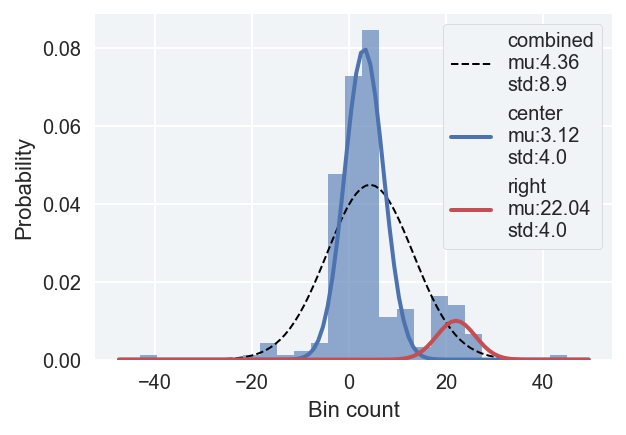

In [68]:
length_df = get_trial_length_dif(all_sessions_dict['JG14_190621'])

fig,ax = plt_fit_normdist(length_df["trial length cor"].dropna(), figsize=set_size(0.8))
save_fig("trial_length_norm", fig)



In [69]:
all_sessions_trial_info_df=list()
for key,se in all_sessions_dict.items():
    all_sessions_trial_info_df.append(get_trial_length_dif(se))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


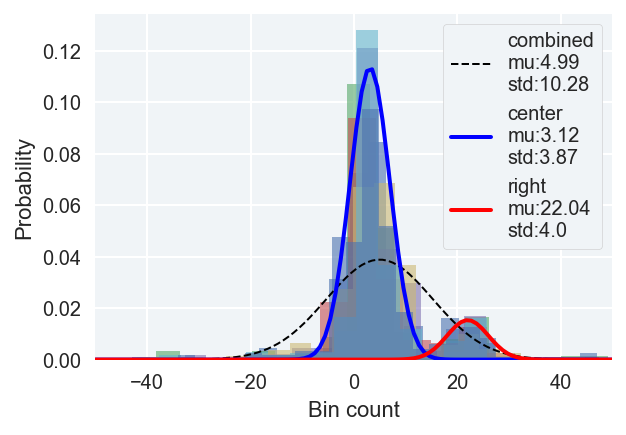

In [70]:
all_list = list()

fig,ax = plt.subplots(1,1,figsize=set_size(0.8))

for length_df in all_sessions_trial_info_df:
    ax = plt_fit_normdist(length_df["trial length cor"].dropna(),ax,norm_fit=False)
    all_list.extend(length_df["trial length cor"].dropna().values)

legend = ax.get_legend()
legend.remove()

ax.set_xlim([-50, 50])

# plot combined fit
mu, std = norm.fit(all_list)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, "k", linestyle='--', linewidth=1,label=f"combined\nmu:{round_up(mu,2)}\nstd:{round_up(std,2)}")

# center
mu=3.12
std=3.87
#x = np.linspace(-25, 29, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p*1.1, "blue", linestyle='-', linewidth=2,label=f"center\nmu:{round_up(mu,2)}\nstd:{round_up(std,2)}")

# right
mu=22.04
std=4
p = norm.pdf(x, mu, std)
#x = np.linspace(12, 33, 100)
ax.plot(x, p/6.5, "red", linestyle='-', linewidth=2,label=f"right\nmu:{round_up(mu,2)}\nstd:{round_up(std,2)}")

ax.legend() #prop={'size': 14}

save_fig("trial_length_norm_all", fig)

In [71]:
event_dif_df = get_event_df(all_sessions_dict)

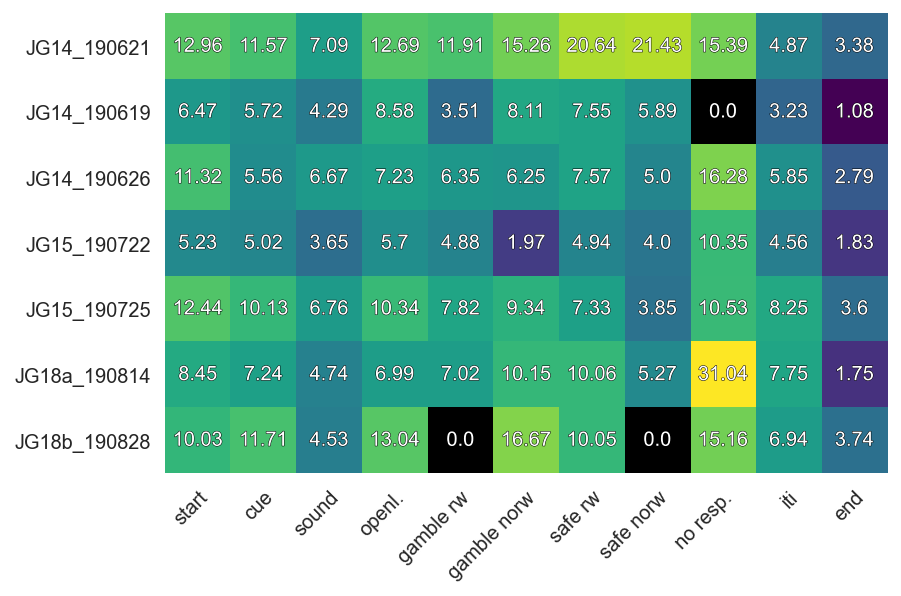

In [72]:
fig, ax = fingerprint_color_map(event_dif_df,figsize=set_size(1.1))
save_fig("event_type_dif", fig)

# Results New System

In [376]:

# Test 1 ==========
# mac
openephys_dir = "/Users/max/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/2 VR Setup/Software/PyBpod Environments/maxland_test_setup/openephys/2021-02-19_15-54-34/Record Node 101/experiment1/recording1"
pybpod_session = "20210219-155417"
pybpod_root = "/Users/max/Google Drive/3 Projekte/Masterarbeit Laborarbeit Neuroscience/2 VR Setup/Software/PyBpod Environments/maxland_test_setup"
# windows
#openephys_dir = r"C:\maxland_RECORDING\openephys\2021-02-19_15-54-34\Record Node 101\experiment1\recording1"

test_1 = SyncPybpod(pybpod_session,pybpod_root,openephys_dir)

all_new_sessions_dict = dict()
all_new_sessions_dict['test_1']=load_pb_session(pybpod_session,pybpod_root,openephys_dir)

20210219-155417 -> behavior


In [377]:
qgrid.show_grid(test_1.combined_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [378]:
qgrid.show_grid(test_1.all_trials_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

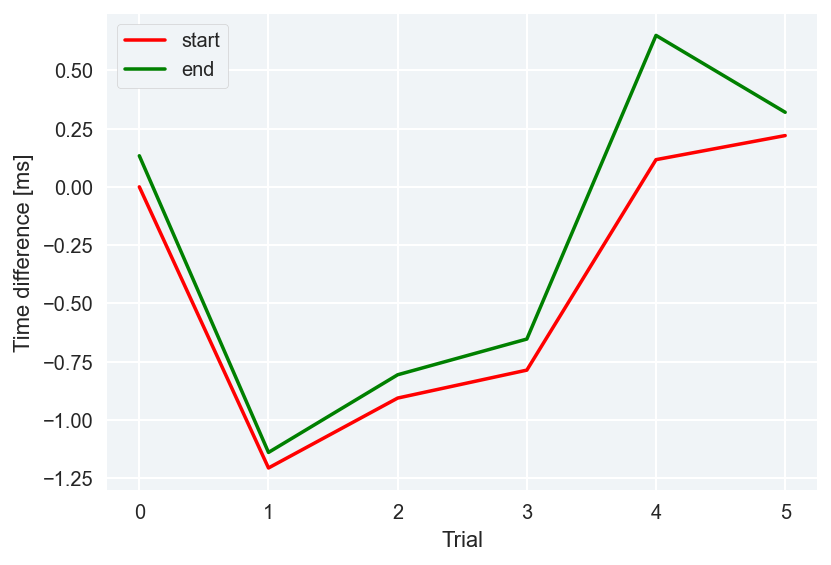

In [173]:
fig,ax = plt_start_stop_dif(test_1.combined_df,figsize=set_size(1.1))

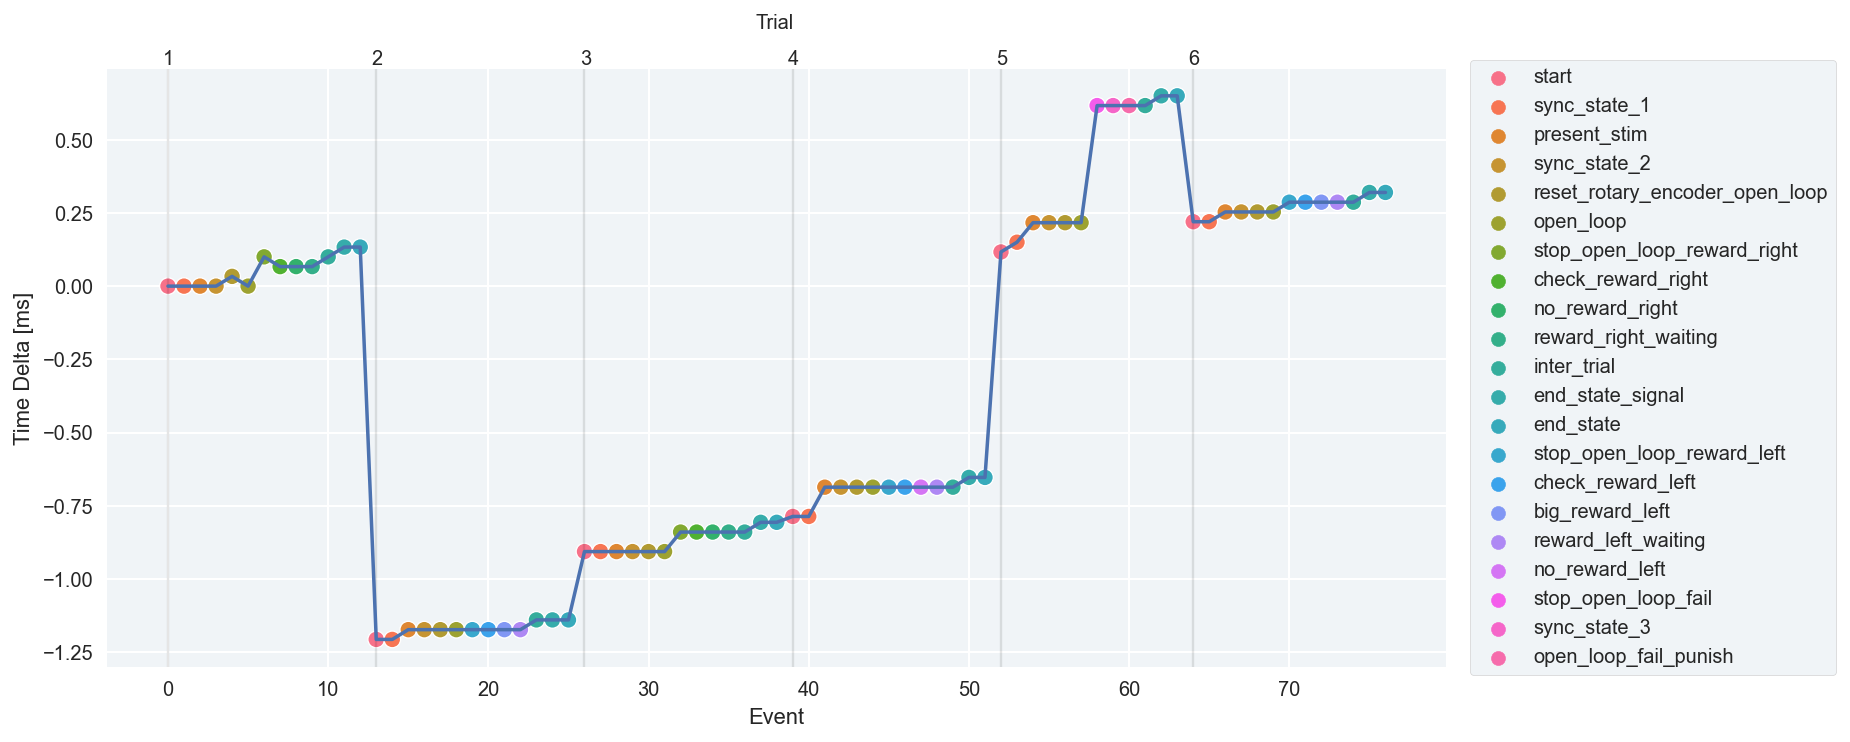

In [174]:
fig,ax = plt_event_dif(test_1.combined_df,plot_all=False)

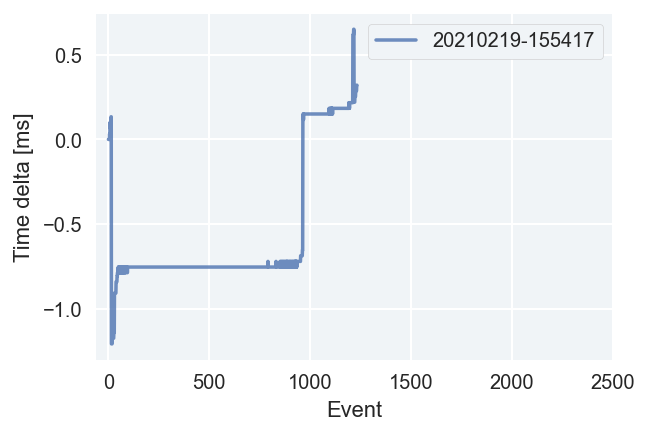

In [175]:
fig,ax = plt_trial_length(all_new_sessions_dict,figsize=set_size(0.8))
#save_fig("ttl_delta", fig)

# Workbench